In [1]:
%load_ext pycodestyle_magic
%flake8_on

In [2]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from sklearn import cluster
from sklearn import metrics
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline

In [3]:
def CreerDataFrameClients(nb_mois):
    df_customers = pd.read_csv('olist_customers_dataset.csv')
    df_items = pd.read_csv('olist_order_items_dataset.csv')
    df_payments = pd.read_csv('olist_order_payments_dataset.csv')
    df_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
    df_orders = pd.read_csv('olist_orders_dataset.csv')
    df_products = pd.read_csv('olist_products_dataset.csv')
    df_translation = pd.read_csv('product_category_name_translation.csv')

    df_orders['order_purchase_timestamp'] = df_orders[
        'order_purchase_timestamp'].astype('datetime64[ns]')
    date_debut = df_orders['order_purchase_timestamp'].min()
    date_fin = date_debut + pd.DateOffset(months=12 + nb_mois)

    df_orders = df_orders[(df_orders['order_purchase_timestamp'] >= date_debut)
                          & (df_orders['order_purchase_timestamp'] < date_fin)]

    df_Produits = pd.merge(df_products, df_translation,
                           on='product_category_name')
    df_Produits.drop(['product_category_name', 'product_name_lenght',
                      'product_description_lenght', 'product_photos_qty',
                      'product_weight_g', 'product_length_cm',
                      'product_height_cm', 'product_width_cm'],
                     axis=1, inplace=True)
    df_Produits = df_Produits.rename(
        columns={'product_category_name_english': 'Catégorie de produit'})

    nouvelles_catégories = {'bed_bath_table': 'Maison',
                            'housewares': 'Maison',
                            'garden_tools': 'Maison',
                            'home_appliances': 'Maison',
                            'small_appliances': 'Maison',
                            'home_construction': 'Maison',
                            'home_confort': 'Maison',
                            'home_appliances_2': 'Maison',
                            'costruction_tools_garden': 'Maison',
                            'small_appliances_home_oven_and_coffee': 'Maison',
                            'home_comfort_2': 'Maison',
                            'la_cuisine': 'Maison',
                            'furniture_decor': 'Mobilier',
                            'office_furniture': 'Mobilier',
                            'furniture_living_room': 'Mobilier',
                            'air_conditioning': 'Mobilier',
                            'kitchen_dining_laundry_garden_furniture':
                            'Mobilier',
                            'furniture_bedroom': 'Mobilier',
                            'furniture_mattress_and_upholstery': 'Mobilier',
                            'furnitures': 'Mobilier',

                            'sports_leisure': 'Loisirs',
                            'toys': 'Loisirs',
                            'musical_instruments': 'Loisirs',
                            'books_general_interest': 'Loisirs',
                            'books_technical': 'Loisirs',
                            'art': 'Loisirs',
                            'cine_photo': 'Loisirs',
                            'dvds_blu_ray': 'Loisirs',
                            'books_imported': 'Loisirs',
                            'party_supplies': 'Loisirs',
                            'music': 'Loisirs',
                            'arts_and_craftmanship': 'Loisirs',
                            'cds_dvds_musicals': 'Loisirs',

                            'computers_accessories': 'Technologies',
                            'telephony': 'Technologies',
                            'electronics': 'Technologies',
                            'consoles_games': 'Technologies',
                            'audio': 'Technologies',
                            'fixed_telephony': 'Technologies',
                            'computers': 'Technologies',
                            'tablets_printing_image': 'Technologies',
                            'watches_gifts': 'Mode',
                            'fashion_bags_accessories': 'Mode',
                            'luggage_accessories': 'Mode',
                            'fashion_shoes': 'Mode',
                            'fashion_male_clothing': 'Mode',
                            'fashion_underwear_beach': 'Mode',
                            'fashio_female_clothing': 'Mode',
                            'fashion_sport': 'Mode',
                            'fashion_childrens_clothes': 'Mode',

                            'health_beauty': 'Beauté_Santé',
                            'perfumery': 'Beauté_Santé',
                            'baby': 'Beauté_Santé',
                            'diapers_and_hygiene': 'Beauté_Santé',

                            'food': 'Nourriture_Boissons',
                            'drinks': 'Nourriture_Boissons',
                            'food_drink': 'Nourriture_Boissons',

                            'auto': 'Autres',
                            'cool_stuff': 'Autres',
                            'stationery': 'Autres',
                            'pet_shop': 'Autres',
                            'construction_tools_construction': 'Autres',
                            'market_place': 'Autres',
                            'construction_tools_lights': 'Autres',
                            'industry_commerce_and_business': 'Autres',
                            'agro_industry_and_commerce': 'Autres',
                            'signaling_and_security': 'Autres',
                            'construction_tools_safety': 'Autres',
                            'christmas_supplies': 'Autres',
                            'costruction_tools_tools': 'Autres',
                            'flowers': 'Autres',
                            'security_and_services': 'Autres'}

    df_Produits['Catégorie de produit'] = df_Produits[
        'Catégorie de produit'].map(nouvelles_catégories)
    df_Produits['Catégorie de produit'] = df_Produits[
        'Catégorie de produit'].astype('category')
    df_Commandes = pd.merge(df_orders, df_items, on='order_id')
    df_Commandes.drop(['order_approved_at', 'order_delivered_carrier_date',
                       'order_delivered_customer_date',
                       'order_estimated_delivery_date', 'seller_id',
                       'shipping_limit_date'], axis=1, inplace=True)

    df_Commandes = pd.merge(df_Commandes, df_reviews, on='order_id')
    df_Commandes.drop(['review_id', 'review_creation_date',
                       'review_answer_timestamp'], axis=1, inplace=True)
    df_Commandes = pd.merge(df_Commandes, df_payments, on='order_id')
    df_Commandes = pd.merge(df_Commandes, df_customers, on='customer_id')
    df_Commandes.drop(['customer_city', 'customer_state',
                       'customer_zip_code_prefix'], axis=1, inplace=True)

    df_Commandes = pd.merge(df_Commandes, df_Produits, on='product_id')

    nbAchatsParCatégorie = df_Commandes.groupby(
        ['customer_unique_id', 'Catégorie de produit']).agg(
        {"customer_unique_id": "nunique"}).unstack()
    nbAchatsParCatégorie.columns = nbAchatsParCatégorie.columns.droplevel(0)
    df_Commandes = pd.merge(df_Commandes, nbAchatsParCatégorie,
                            on='customer_unique_id')

    df_Commandes = pd.merge(df_Commandes,
                            df_Commandes.groupby(['customer_id']).agg(
                                {'payment_installments': 'max'}),
                            on='customer_id').rename(
        columns={'payment_installments_x': 'Nombre de paiements',
                 'payment_installments_y': 'Nombre de paiements Max'})

    df_Commandes = pd.merge(df_Commandes,
                            df_Commandes.groupby(['customer_id']).agg(
                                {'payment_sequential': 'max'}),
                            on='customer_id').rename(
        columns={'payment_sequential_x': 'Nombre de moyens de paiement',
                 'payment_sequential_y': 'Nombre de moyens de paiement Max'})

    df_Commandes['Paiement en une fois'] = np.where(
        df_Commandes['Nombre de paiements Max'] == 1, 1, 0)
    df_Commandes['Paiement en plusieurs fois'] = np.where(
        df_Commandes['Nombre de paiements Max'] > 1, 1, 0)

    df_Commandes['Un moyen de paiement'] = np.where(
        df_Commandes['Nombre de moyens de paiement Max'] == 1, 1, 0)
    df_Commandes['Plusieurs moyens de paiement'] = np.where(
        df_Commandes['Nombre de moyens de paiement Max'] > 1, 1, 0)

    df_Clients = df_Commandes.copy()
    df_Clients.drop(['order_status', 'customer_id',
                     'Catégorie de produit'], axis=1, inplace=True)

    df_Clients = pd.merge(df_Clients,
                          df_Commandes.groupby(['customer_unique_id']).agg(
                              {'price': 'min'}),
                          on='customer_unique_id').rename(
        columns={'price_x': 'price', 'price_y': 'Montant Min'})

    df_Clients = pd.merge(df_Clients,
                          df_Commandes.groupby(['customer_unique_id']).agg(
                              {'price': 'max'}),
                          on='customer_unique_id').rename(
        columns={'price_x': 'price', 'price_y': 'Montant Max'})

    df_Clients = pd.merge(df_Clients,
                          df_Clients.groupby('customer_unique_id').agg(
                              {'order_purchase_timestamp': 'nunique'}),
                          on='customer_unique_id').rename(
        columns={'order_purchase_timestamp_x': 'Date de la commande',
                 'order_purchase_timestamp_y': 'Nombre de commandes'})

    df_Clients = pd.merge(df_Clients,
                          df_Clients.groupby(['customer_unique_id']).agg(
                              {'review_score': 'mean'}),
                          on='customer_unique_id').rename(
        columns={'review_score_x': 'review_score',
                 'review_score_y': 'Note Moyenne'})

    df_Clients = pd.merge(df_Clients,
                          df_Clients.groupby(['customer_unique_id']).agg(
                              {'order_item_id': 'nunique'}),
                          on='customer_unique_id').rename(
        columns={'order_item_id_x': 'order_item_id',
                 'order_item_id_y': 'Nombre d\'objets Max'})

    a = df_Clients[['customer_unique_id', 'price', 'Nombre d\'objets Max']]
    a = a.drop_duplicates()
    a = pd.merge(a, a.groupby(['customer_unique_id']).agg(
        {'Nombre d\'objets Max': 'sum'}),
                 on='customer_unique_id').rename(
        columns={'Nombre d\'objets Max_x': 'Nombre d\'objets Max',
                 'Nombre d\'objets Max_y': 'Nombre d\'objets Total'})
    a = a[['customer_unique_id', 'Nombre d\'objets Total']]

    df_Clients = pd.merge(df_Clients, a, on='customer_unique_id')
    df_Clients = df_Clients.drop_duplicates()

    df_Clients['Date de la commande'] = df_Clients[
        'Date de la commande'].astype('datetime64')
    df_Clients['Récence'] = (df_Clients['Date de la commande'].max()
                             - df_Clients['Date de la commande'])
    df_Clients['Récence'] = df_Clients['Récence'].astype('timedelta64[D]')

    df_Clients = pd.merge(df_Clients,
                          df_Clients.groupby(['customer_unique_id']).agg(
                              {'Date de la commande': 'min'}),
                          on='customer_unique_id').rename(
        columns={'Date de la commande_x': 'Date de la commande',
                 'Date de la commande_y': 'Première commande'})

    df_Clients = pd.merge(df_Clients,
                          df_Clients.groupby(['customer_unique_id']).agg(
                              {'Date de la commande': 'max'}),
                          on='customer_unique_id').rename(
        columns={'Date de la commande_x': 'Date de la commande',
                 'Date de la commande_y': 'Dernière commande'})

    df_Clients['Fréquence'] = ((df_Clients['Dernière commande']
                                - df_Clients['Première commande'])
                               / df_Clients['Nombre de commandes'])
    df_Clients['Fréquence'] = df_Clients['Fréquence'].astype('timedelta64[D]')

    df_Clients.drop(['order_id', 'order_item_id', 'product_id',
                     'freight_value', 'review_score', 'review_comment_title',
                     'review_comment_message', 'Nombre de paiements',
                     'Nombre de moyens de paiement', 'payment_value',
                     'Dernière commande', 'Première commande'],
                    axis=1, inplace=True)

    df_Clients = pd.merge(df_Clients,
                          df_Clients.groupby(['customer_unique_id']).agg(
                              {'Récence': 'min'}),
                          on='customer_unique_id').rename(
        columns={'Récence_y': 'Récence'})
    df_Clients.drop('Récence_x', axis=1, inplace=True)
    df_Clients = df_Clients.drop_duplicates()

    df_Clients = pd.merge(df_Clients,
                          df_Clients.groupby(['customer_unique_id']).agg(
                              {'price': 'mean'}),
                          on='customer_unique_id').rename(
        columns={'price_x': 'price', 'price_y': 'Montant Moyen'})

    df_Clients = pd.merge(df_Clients,
                          df_Clients.groupby(['customer_unique_id']).agg(
                              {'price': 'sum'}),
                          on='customer_unique_id').rename(
        columns={'price_x': 'price', 'price_y': 'Montant'})
    df_Clients = df_Clients.drop_duplicates(subset=['customer_unique_id'])

    indexes = df_Clients['customer_unique_id']
    df_Clients = df_Clients[['Récence', 'Fréquence', 'Montant',
                             'Montant Moyen', 'Montant Min', 'Montant Max',
                             'Nombre de commandes', 'Nombre d\'objets Max',
                             'Nombre d\'objets Total']]

    # Standardisation
    std_scale = preprocessing.StandardScaler().fit(df_Clients)
    df_Clients_std = pd.DataFrame(std_scale.transform(df_Clients))
    df_Clients_std.columns = df_Clients.columns

    return df_Clients_std, indexes

265:1: W293 blank line contains whitespace


In [4]:
df_, indexes_ = CreerDataFrameClients(0)

# ACP
X_ACP = df_.values
pca = decomposition.PCA(n_components=4)
pca.fit(X_ACP)
X_projected = pca.transform(X_ACP)
X_ = pd.DataFrame(X_projected[:, :4])
colonnes = []
for i in range(X_.shape[1]):
    colonnes.append('Facteur ' + str(i+1))
X_.columns = colonnes
X_.set_index(indexes_, inplace=True)

kmeans_ = Pipeline([("preprocessor", QuantileTransformer(
    output_distribution='normal')),
                    ("kmeans", KMeans(4, init='k-means++', random_state=10))])
kmeans_.fit(X_)
periode = []
ARI_score = []

for nb_mois in np.arange(0, 12, 2):
    periode.append(nb_mois)
    df, indexes = CreerDataFrameClients(nb_mois)

    # ACP
    X_ACP1 = df.values
    X_projected1 = pca.transform(X_ACP1)
    X = pd.DataFrame(X_projected1[:, :4])
    colonnes = []
    for i in range(X.shape[1]):
        colonnes.append('Facteur ' + str(i+1))
    X.columns = colonnes
    X.set_index(indexes, inplace=True)

    kmeans = Pipeline([("preprocessor",
                        QuantileTransformer(output_distribution='normal')),
                       ("kmeans", KMeans(
                           4, init='k-means++', random_state=10))])
    kmeans.fit(X)

    labels = kmeans.predict(X)
    labels_ = kmeans_.predict(X)

    ari = metrics.adjusted_rand_score(labels, labels_)
    ARI_score.append(ari)

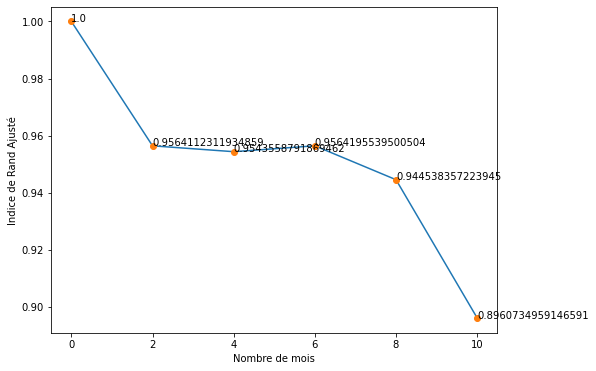

In [22]:
plt.figure(figsize=(8, 6))
plt.plot(periode, ARI_score)
plt.plot(periode, ARI_score, 'o')
plt.xlabel('Nombre de mois')
plt.ylabel('Indice de Rand Ajusté')
for i in range(len(periode)):
    plt.text(periode[i], ARI_score[i], ARI_score[i])
plt.show()

In [19]:
pd.DataFrame(np.array([periode, ARI_score]).transpose(),
             columns=['periode', 'ARI'])

,periode,ARI
0,0.0,1.000000
1,2.0,0.956411
2,4.0,0.954356
3,6.0,0.956420
4,8.0,0.944538
5,10.0,0.896073
